### Get Data

In [1]:
# Import libraries
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 100

In [3]:
# Check if the path exists, if not create it.
if not os.path.exists(IMAGES_PATH):
    os.makedirs(IMAGES_PATH)

cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [5]:
# Annotate images with labelme
!labelme

### Review dataset

In [6]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth(limit GPU growth)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
### Load Images into TF Data pipeline
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [10]:
images.as_numpy_iterator().next()

b'data\\images\\616d8a0c-1054-11ee-a5f7-f89e94f9bd2e.jpg'

In [11]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [12]:
images = images.map(load_image)

In [13]:
images.as_numpy_iterator().next()

array([[[80, 80, 78],
        [80, 80, 78],
        [80, 82, 79],
        ...,
        [65, 67, 54],
        [65, 67, 54],
        [66, 68, 55]],

       [[79, 79, 77],
        [80, 80, 78],
        [79, 81, 78],
        ...,
        [65, 67, 54],
        [66, 66, 54],
        [66, 68, 55]],

       [[80, 80, 78],
        [80, 80, 78],
        [79, 81, 78],
        ...,
        [66, 66, 54],
        [68, 66, 54],
        [67, 67, 55]],

       ...,

       [[82, 78, 77],
        [82, 78, 77],
        [82, 78, 75],
        ...,
        [76, 77, 72],
        [74, 76, 73],
        [74, 76, 71]],

       [[82, 78, 75],
        [82, 78, 75],
        [82, 78, 75],
        ...,
        [75, 77, 74],
        [74, 76, 75],
        [74, 76, 73]],

       [[82, 78, 75],
        [82, 78, 75],
        [82, 78, 75],
        ...,
        [75, 77, 76],
        [75, 77, 76],
        [74, 76, 75]]], dtype=uint8)

In [14]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [15]:
## View Images
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [18]:
### Split Data

In [19]:
# Manually split data into train, test and val. 
# train = 80
# test = 10
# val = 10

In [21]:
# Move matching labels
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)    

### Apply Image Augmentation

In [25]:
# import library
import albumentations as alb

#create pipeline
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [27]:
# Load test image and annotation
img = cv2.imread(os.path.join('data','train', 'images','4aab0ce0-1054-11ee-9bc3-f89e94f9bd2e.jpg'))
with open(os.path.join('data', 'train', 'labels', '4aab0ce0-1054-11ee-9bc3-f89e94f9bd2e.json'), 'r') as f:
    label = json.load(f)
label['shapes'][0]['points']

[[169.99999999999997, 168.9473684210526],
 [398.94736842105266, 429.47368421052624]]

In [28]:
print(img.shape)

(480, 640, 3)


In [29]:
# Extract Coordinates and Rescale to Match Image Resolution
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [30]:
coords

[169.99999999999997, 168.9473684210526, 398.94736842105266, 429.47368421052624]

In [31]:
coords = list(np.divide(coords, [640,480,640,480]))

In [32]:
coords

[0.26562499999999994,
 0.35197368421052627,
 0.6233552631578948,
 0.894736842105263]

In [33]:
# Apply augmentations
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [34]:
augmented['bboxes'][0][2:]

(0.8198830409356725, 0.9366081871345028)

In [35]:
augmented['bboxes']

[(0.31111111111111106,
  0.35766081871345023,
  0.8198830409356725,
  0.9366081871345028)]

In [ ]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

### Build Augmentation pipeline

In [38]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(100):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [39]:
#Load augmented images to tf dataset
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [43]:
train_images.as_numpy_iterator().next()

array([[[0.529902  , 0.4730392 , 0.4981005 ],
        [0.51096815, 0.4536152 , 0.46746323],
        [0.46832108, 0.44332108, 0.44381127],
        ...,
        [0.6155025 , 0.53707105, 0.5449142 ],
        [0.59914213, 0.5047181 , 0.53639704],
        [0.6127451 , 0.5083946 , 0.55134803]],

       [[0.5401348 , 0.4708946 , 0.499326  ],
        [0.5332721 , 0.46017158, 0.48241422],
        [0.5074142 , 0.4704657 , 0.47591913],
        ...,
        [0.5908088 , 0.51531863, 0.5314951 ],
        [0.59319854, 0.47702205, 0.51390934],
        [0.60226715, 0.48204657, 0.527451  ]],

       [[0.53639704, 0.48186275, 0.5063726 ],
        [0.54264706, 0.475     , 0.4985294 ],
        [0.5403186 , 0.46666667, 0.49019608],
        ...,
        [0.5574755 , 0.49454656, 0.5063726 ],
        [0.56219363, 0.4858456 , 0.502451  ],
        [0.55514705, 0.47181374, 0.4997549 ]],

       ...,

       [[0.71341914, 0.6467525 , 0.6702819 ],
        [0.7151348 , 0.6466299 , 0.67015934],
        [0.7206495 , 0

### Prepare Labels

In [44]:
# Build function to load label
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [45]:
# Load labels
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

### Combine label and image samples

In [46]:
# Check partition length
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(8000, 8000, 1000, 1000, 1000, 1000)

In [47]:
# Create final dataset
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

#for test
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

#for val
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)


In [48]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.5063 , 0.279  , 0.9507 , 0.899  ],
        [0.5786 , 0.2837 , 0.988  , 0.8687 ],
        [0.5024 , 0.3328 , 0.9585 , 0.883  ],
        [0.5786 , 0.1318 , 0.976  , 0.6875 ],
        [0.06128, 0.1934 , 0.5234 , 0.6787 ],
        [0.3792 , 0.2798 , 0.765  , 0.859  ],
        [0.2927 , 0.12024, 0.714  , 0.6113 ],
        [0.485  , 0.2856 , 0.965  , 0.8647 ]], dtype=float16))

In [ ]:
# View image and annotation
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

### Build Model

In [50]:
# Import libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [51]:
# Load vgg
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [52]:
# Build instance of network
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [53]:
# Test neural network
facetracker = build_model()
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [54]:
X, y = train.as_numpy_iterator().next()

In [56]:
X.shape

(8, 120, 120, 3)

In [57]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 [==============================] - 5s 5s/step


(array([[0.34244585],
        [0.33131596],
        [0.3457285 ],
        [0.34916842],
        [0.35137227],
        [0.3400382 ],
        [0.35959402],
        [0.34443742]], dtype=float32),
 array([[0.58844733, 0.43972236, 0.6055851 , 0.49078286],
        [0.6827348 , 0.40024278, 0.5409147 , 0.5129595 ],
        [0.6784475 , 0.44867283, 0.56897646, 0.5604546 ],
        [0.56533414, 0.42630547, 0.57095253, 0.44210625],
        [0.66796196, 0.4210659 , 0.53555727, 0.528278  ],
        [0.61810786, 0.42250666, 0.5150905 , 0.4663854 ],
        [0.5997051 , 0.45990095, 0.60800505, 0.4865854 ],
        [0.6476159 , 0.46018735, 0.582319  , 0.4739559 ]], dtype=float32))

### Define Loss and Optimizers

In [58]:
# Define lr
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

# Define optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [60]:
# create localization and classification loss

def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [61]:
# test out loss metrics
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.4249887>

In [62]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0629816>

In [63]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.4249887>

### Train Network

In [65]:
# create custom model class
class FaceDetector(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [67]:
model = FaceDetector(facetracker)

In [68]:
model.compile(opt, classloss, regressloss)

###### Train

In [69]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
1000/1000 [==============================] - 46s 38ms/step - total_loss: 0.0508 - class_loss: 0.0037 - regress_loss: 0.0489 - val_total_loss: 0.0302 - val_class_loss: 1.8478e-06 - val_regress_loss: 0.0302
Epoch 2/10
1000/1000 [==============================] - 42s 38ms/step - total_loss: 0.0137 - class_loss: 1.6669e-06 - regress_loss: 0.0137 - val_total_loss: 0.0430 - val_class_loss: 2.5332e-07 - val_regress_loss: 0.0430
Epoch 3/10
1000/1000 [==============================] - 41s 38ms/step - total_loss: 0.0072 - class_loss: 4.5549e-07 - regress_loss: 0.0072 - val_total_loss: 0.0500 - val_class_loss: 2.8312e-07 - val_regress_loss: 0.0500
Epoch 4/10
1000/1000 [==============================] - 42s 38ms/step - total_loss: 0.0052 - class_loss: 2.2713e-07 - regress_loss: 0.0052 - val_total_loss: 0.0702 - val_class_loss: 1.3411e-07 - val_regress_loss: 0.0702
Epoch 5/10
1000/1000 [==============================] - 42s 38ms/step - total_loss: 0.0042 - class_loss: 1.5479e-07 - regres

In [70]:
# plot performance
hist.history

{'total_loss': [0.030742038041353226,
  0.011462192982435226,
  0.0036472741048783064,
  0.007099096663296223,
  0.0018770410679280758,
  0.004020144231617451,
  0.002225002972409129,
  0.0019761009607464075,
  0.0009889047360047698,
  0.002266161609441042],
 'class_loss': [1.832846351135231e-06,
  1.2218974916322622e-06,
  7.4505820180093e-08,
  4.6193628122637165e-07,
  -0.0,
  -0.0,
  4.4703490686970326e-08,
  -0.0,
  -0.0,
  -0.0],
 'regress_loss': [0.030741121619939804,
  0.011461582034826279,
  0.0036472368519753218,
  0.007098865695297718,
  0.0018770410679280758,
  0.004020144231617451,
  0.0022249806206673384,
  0.0019761009607464075,
  0.0009889047360047698,
  0.002266161609441042],
 'val_total_loss': [0.030196193605661392,
  0.04295247420668602,
  0.049974072724580765,
  0.07019924372434616,
  0.039683252573013306,
  0.03186529502272606,
  0.03635796532034874,
  0.04615739732980728,
  0.0630645826458931,
  0.03875027969479561],
 'val_class_loss': [1.8477511503078858e-06,
  2

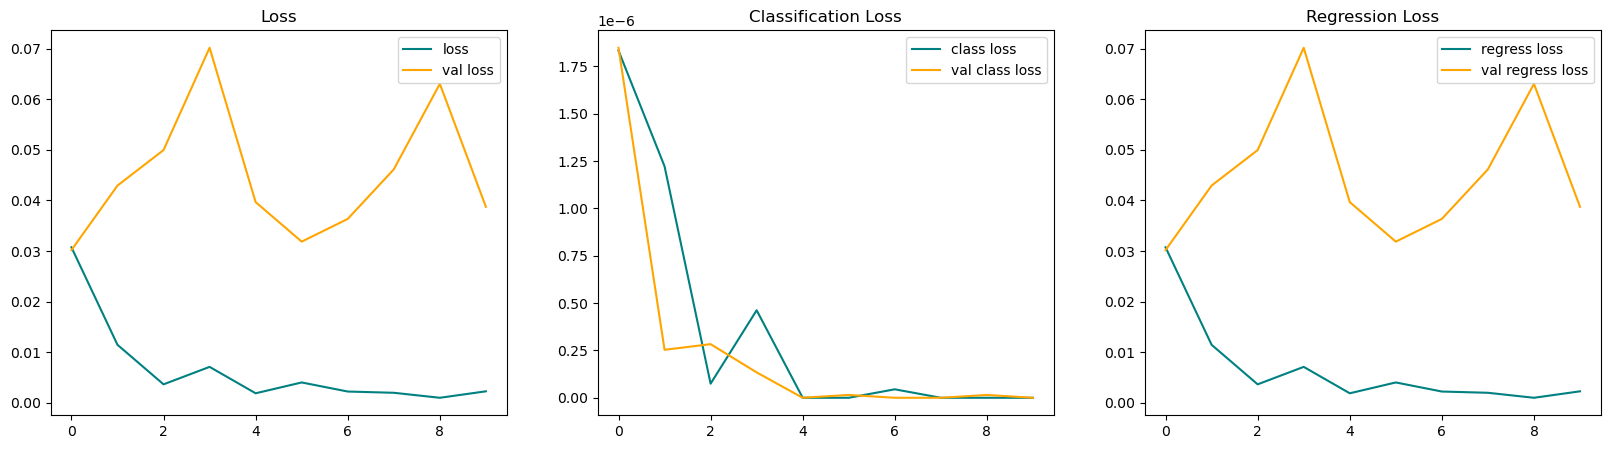

In [71]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

### Make Predictions

In [72]:
# Make Predictions on test data
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 17ms/step


In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### Save Model

In [74]:
from tensorflow.keras.models import load_model
facetracker.save('facetracker.h5')
facetracker = load_model('facetracker.h5')

In [77]:
# Real time detection
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
